Author: Riddhisha Chitwadgi
Purpose: Time series models

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [178]:
df = pd.read_csv('cleaned_data.csv')

In [179]:
# Convert 'SOLD_AT' and 'RELEASEDATE' to datetime format
df['SOLD_AT'] = pd.to_datetime(df['SOLD_AT'], format='ISO8601', errors='coerce')

df['RELEASEDATE'] = pd.to_datetime(df['RELEASEDATE'], format='%Y-%m-%d', errors='coerce')

In [180]:
df.head()

,SKU,CONDITION,GENDER,SOLD_AT,SOLD_PRICE,SOURCE,SIZE_VALUE,BRAND,NAME,COLORWAY,COLOR,SILHOUETTE,RETAILPRICE,RELEASEDATE,IS_COLLAB,COLLABORATOR
0,AJ5997-880,is_new,men,2021-01-01 00:02:17.549000+00:00,235.0,alias,15.0,Jordan,Jordan 1 Retro High Gatorade Orange Peel,Orange Peel/Orange Peel,orange,Air Jordan 1,175,2017-12-26,False,NaN
1,CD0461-007,is_new,women,2021-01-01 00:03:12+00:00,750.0,stockx,8.5,Jordan,Jordan 1 Retro High Twist (Special Box) (Women's),Black/Black-Metallic Gold-White,black,Air Jordan 1,160,2019-05-02,False,NaN
2,CK6637-104,is_new,men,2021-01-01 00:05:03+00:00,340.0,stockx,12.0,Jordan,Jordan 1 Retro High Zoom White Racer Blue,White/Racer Blue-White,white,Air Jordan 1,175,2020-03-14,False,NaN
3,AQ9129-200,is_new,women,2021-01-01 00:06:12+00:00,347.0,stockx,9.0,Jordan,Jordan 4 Retro Fossil (Women's),Mushrom/Multi-Color-Black-Fossil-Pale Ivory,black,Air Jordan 4,190,2019-09-19,False,NaN
4,CJ1495-300,is_new,men,2021-01-01 00:06:15+00:00,120.0,stockx,8.5,Jordan,Jordan Zoom Trunner Ultimate Rage Green,Rage Green/Black-Vivid Purple-Volt,green,Jordan Zoom Trunner Ultimate,150,2020-05-01,False,NaN


In [181]:
# Convert 'SIZE_VALUE' to a categorical variable
df['SIZE_VALUE'] = df['SIZE_VALUE'].astype('object')

In [182]:
# Update 'COLLABORATOR' to 'None' where 'IS_COLLAB' is False
df.loc[df['IS_COLLAB'] == False, 'COLLABORATOR'] = 'None'

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956006 entries, 0 to 7956005
Data columns (total 16 columns):
 #   Column        Dtype              
---  ------        -----              
 0   SKU           object             
 1   CONDITION     object             
 2   GENDER        object             
 3   SOLD_AT       datetime64[ns, UTC]
 4   SOLD_PRICE    float64            
 5   SOURCE        object             
 6   SIZE_VALUE    object             
 7   BRAND         object             
 8   NAME          object             
 9   COLORWAY      object             
 10  COLOR         object             
 11  SILHOUETTE    object             
 12  RETAILPRICE   int64              
 13  RELEASEDATE   datetime64[ns]     
 14  IS_COLLAB     bool               
 15  COLLABORATOR  object             
dtypes: bool(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 918.1+ MB


In [184]:
df.isnull().sum()

SKU             0
CONDITION       0
GENDER          0
SOLD_AT         0
SOLD_PRICE      0
SOURCE          0
SIZE_VALUE      0
BRAND           0
NAME            0
COLORWAY        0
COLOR           0
SILHOUETTE      0
RETAILPRICE     0
RELEASEDATE     0
IS_COLLAB       0
COLLABORATOR    0
dtype: int64

In [185]:
# Set 'SOLD_AT' as the index
df.set_index('SOLD_AT', inplace=True)

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns from the DataFrame
df_numeric = df.drop(columns=non_numeric_columns)

#extracting target variable
df_target = df['SOLD_PRICE']

# Resample data to monthly frequency and aggregate by mean
df_monthly = df_target.resample('M').mean()

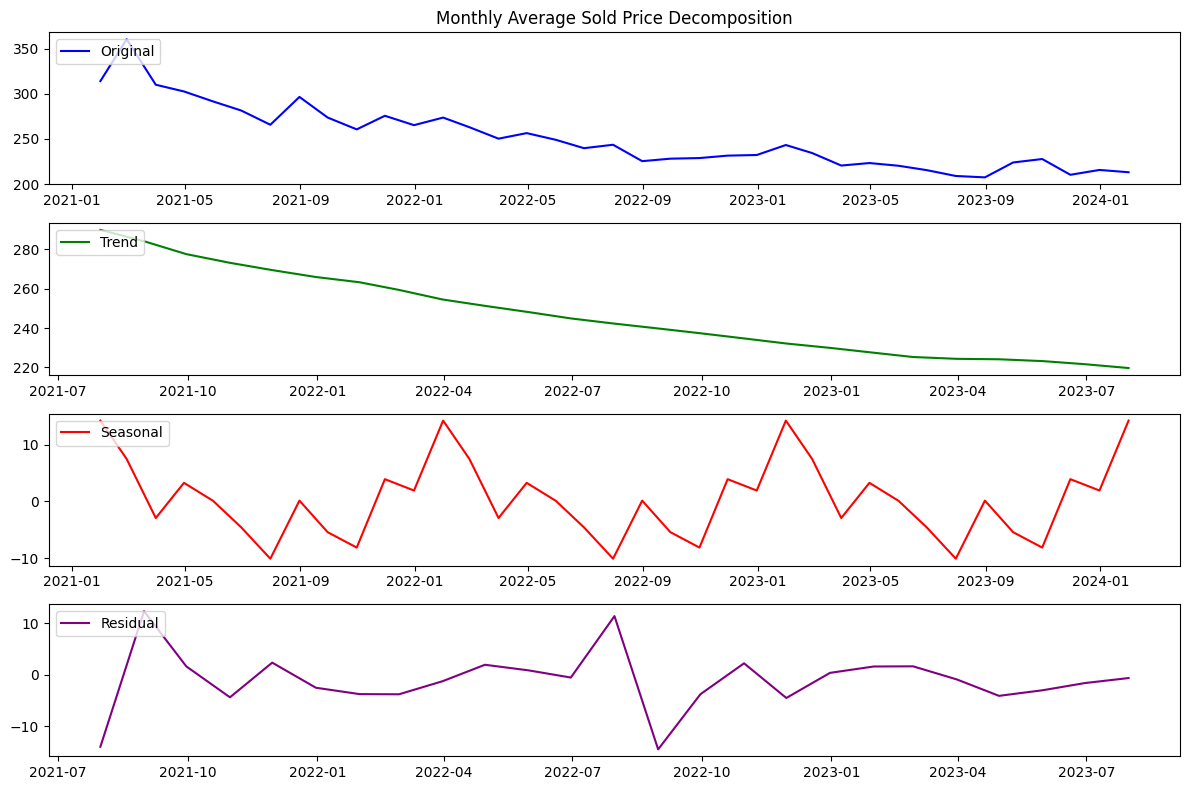

In [186]:
# Resample the data to get monthly averages
monthly_avg_sold_price = df['SOLD_PRICE'].resample('M').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_avg_sold_price, model='additive', period=12)  # Assuming seasonality of 12 months

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_avg_sold_price, label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Monthly Average Sold Price Decomposition')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [187]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

In [188]:
#ADF Test for stationarity
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.425468
p-value: 0.010121
	1%: -3.700
	5%: -2.976
	10%: -2.628


In [189]:
# Perform KPSS test
result = kpss(train)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 0.7805290312685474
P-value: 0.01


/var/folders/zn/frtcx_8d3mg0lvjd20vlbdh00000gn/T/ipykernel_33850/2286495329.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(train)


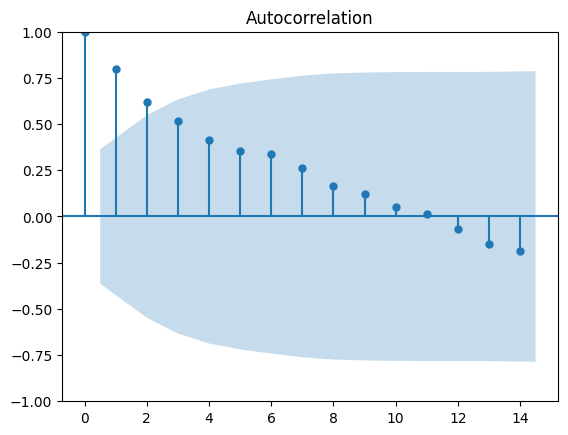

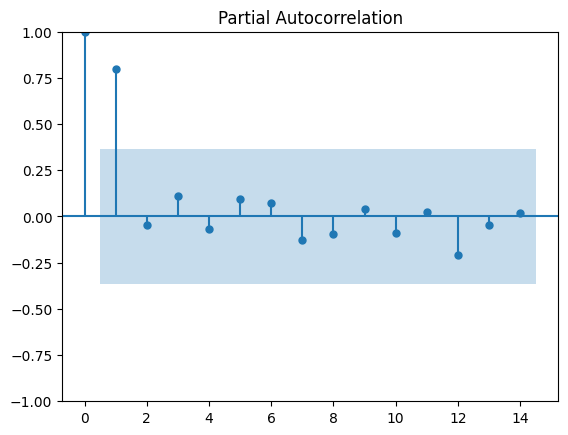

In [190]:
plot_acf(train)
plot_pacf(train)
plt.show()

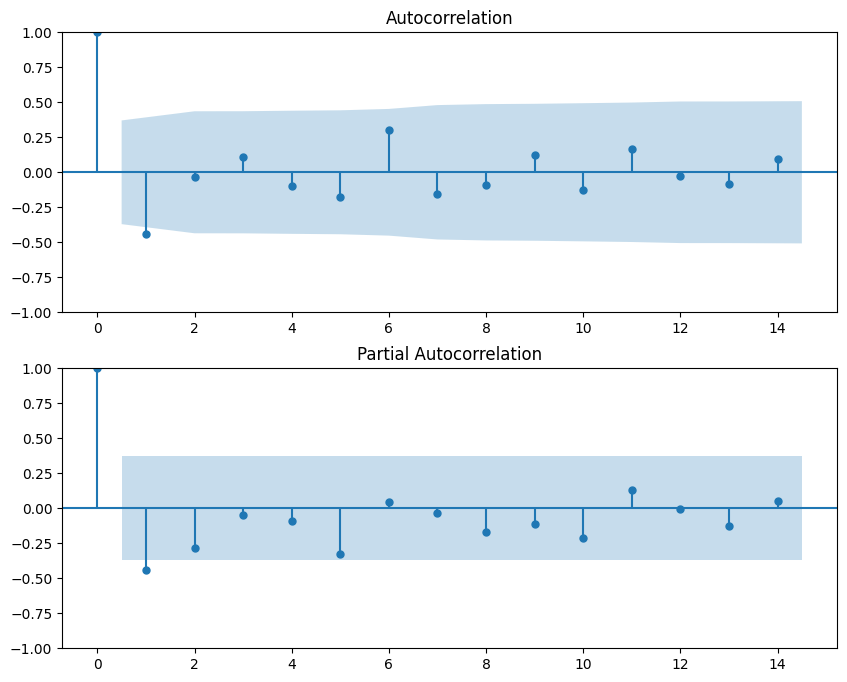

In [191]:
#differencing the data due to kpss
differenced_data = train.diff().dropna()

# Plot ACF and PACF of the differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(differenced_data, ax=ax1)
plot_pacf(differenced_data, ax=ax2)
plt.show()


In [192]:
# Define function for performance metric
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Model RMSE: 7.418140345722545
ARIMA Model MAE: 6.064721486739771
ARIMA Model MAPE: 2.7863511082628363
                               SARIMAX Results                                
Dep. Variable:             SOLD_PRICE   No. Observations:                   29
Model:                 ARIMA(1, 1, 9)   Log Likelihood                -112.437
Date:                Wed, 03 Apr 2024   AIC                            246.874
Time:                        11:09:27   BIC                            261.528
Sample:                    01-31-2021   HQIC                           251.354
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4569      1.101     -0.415      0.678      -2.615       1.701
ma.L1         -0.0074  

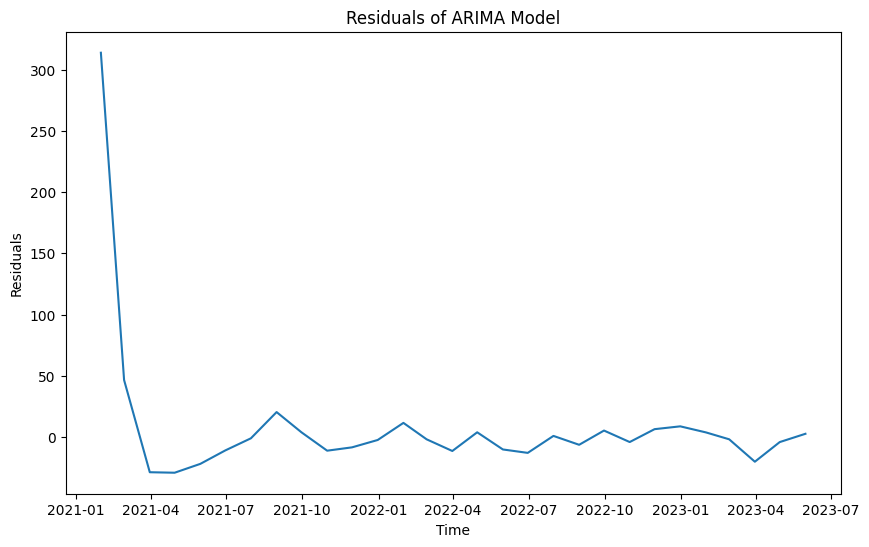

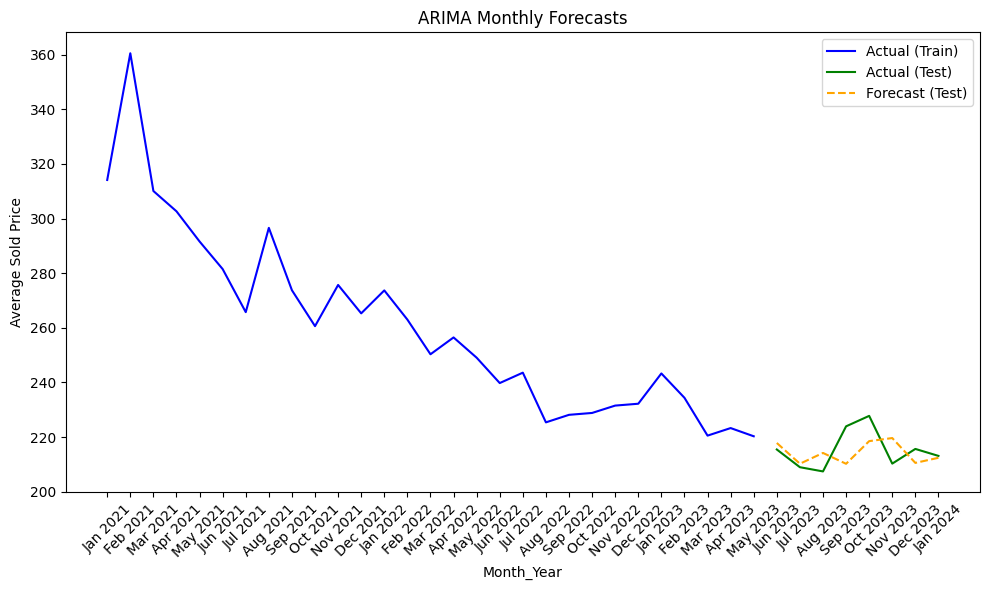

In [193]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
import numpy as np


# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 9))
model_fit = model.fit()
            
# Make predictions
train_pred = model_fit.predict(start=train.index[0], end=train.index[-1], dynamic=False)
test_pred = model_fit.forecast(steps=len(test))
            
# Calculate performance metrics
rmse_test = calculate_rmse(test.values, test_pred)
print('ARIMA Model RMSE:', rmse_test)
mae_test = calculate_mae(test.values, test_pred)
print('ARIMA Model MAE:', mae_test)
mape_test = calculate_mape(test.values, test_pred)
print('ARIMA Model MAPE:', mape_test)

# Convert index to 'Month_Year' format
train.index = train.index.strftime('%b %Y')
test.index = test.index.strftime('%b %Y')

print(model_fit.summary())   

#Residual plot
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot monthly forecasts
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Actual (Train)', color='blue')
plt.plot(test.index, test, label='Actual (Test)', color='green')
plt.plot(test.index, test_pred, label='Forecast (Test)', linestyle='--', color='orange')
plt.title('ARIMA Monthly Forecasts')
plt.xlabel('Month_Year')
plt.ylabel('Average Sold Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [194]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

Holtz winter Model RMSE: 11.178888243563964
Holtz winter Model MAE: 8.342997179151908
Holtz winter Model MAPE: 3.7878291123364214
                       ExponentialSmoothing Model Results                       
Dep. Variable:               SOLD_PRICE   No. Observations:                   29
Model:             ExponentialSmoothing   SSE                           2091.034
Optimized:                         True   AIC                            156.065
Trend:                   Multiplicative   BIC                            177.942
Seasonal:                      Additive   AICC                           224.465
Seasonal Periods:                    12   Date:                 Wed, 03 Apr 2024
Box-Cox:                          False   Time:                         11:09:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-----------------------------------------------------------

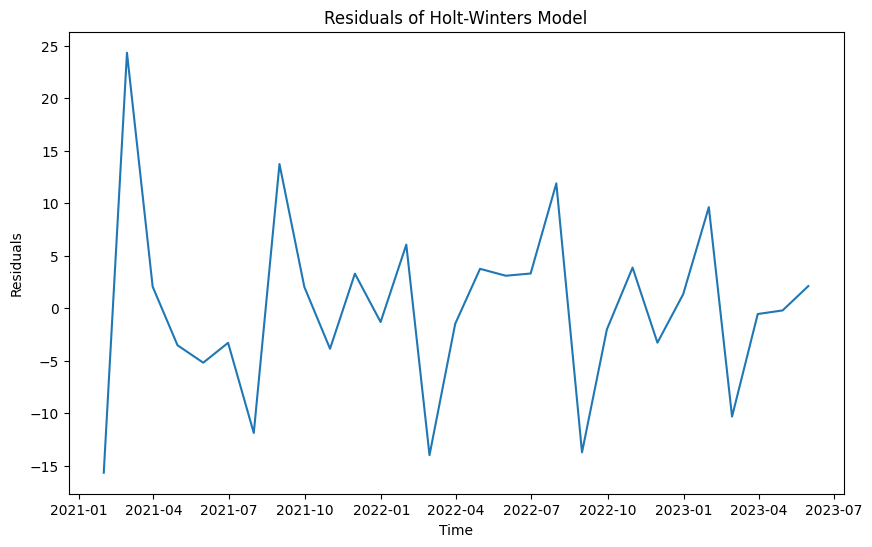

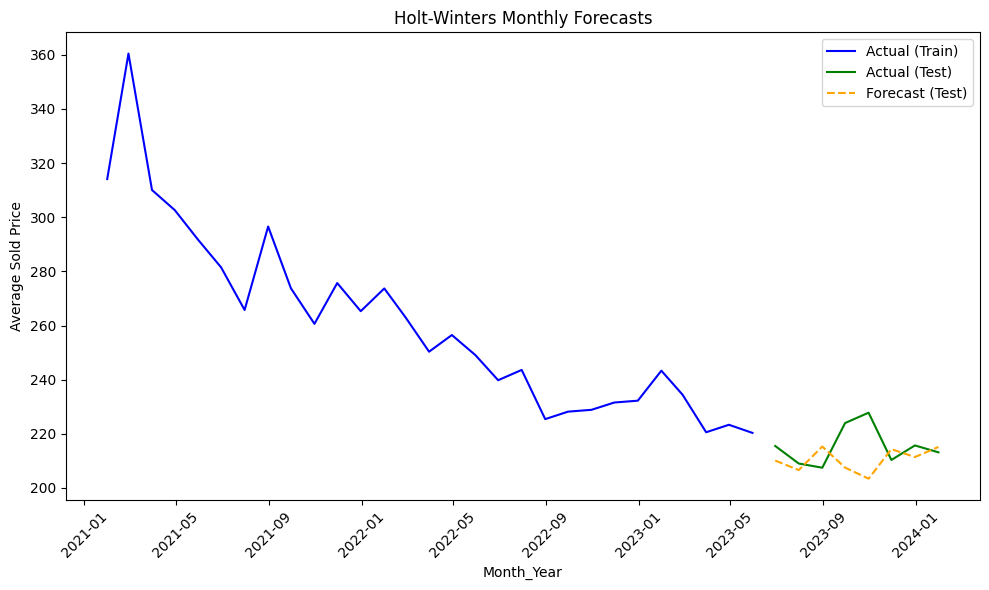

In [195]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
model_hw = ExponentialSmoothing(train, trend='Multiplicative', seasonal='Additive', seasonal_periods=12, initialization_method='estimated')
model_hw_fit = model_hw.fit()

# Make predictions
train_pred_hw = model_hw_fit.fittedvalues
test_pred_hw = model_hw_fit.forecast(steps=len(test))

# Calculate performance metrics
rmse_hw = calculate_rmse(test.values, test_pred_hw)
print('Holtz winter Model RMSE:', rmse_hw)
mae_hw = calculate_mae(test.values, test_pred_hw)
print('Holtz winter Model MAE:', mae_hw)
mape_hw = calculate_mape(test.values, test_pred_hw)
print('Holtz winter Model MAPE:', mape_hw)

# Print summary of the Holt-Winters model
print(model_hw_fit.summary())

# Residual plot
residuals_hw = train - train_pred_hw
plt.figure(figsize=(10, 6))
plt.plot(residuals_hw)
plt.title('Residuals of Holt-Winters Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot monthly forecasts
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Actual (Train)', color='blue')
plt.plot(test.index, test, label='Actual (Test)', color='green')
plt.plot(test.index, test_pred_hw, label='Forecast (Test)', linestyle='--', color='orange')
plt.title('Holt-Winters Monthly Forecasts')
plt.xlabel('Month_Year')
plt.ylabel('Average Sold Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


11:40:55 - cmdstanpy - INFO - Chain [1] start processing
11:40:55 - cmdstanpy - INFO - Chain [1] done processing
11:40:55 - cmdstanpy - INFO - Chain [1] start processing
11:40:55 - cmdstanpy - INFO - Chain [1] done processing
11:40:55 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:04 - cmdstanpy - INFO - Chain [1] done processing
11:41:04 - cmdstanpy - INFO - Chain [1] start processing
11:41:12 - cmdstanpy - INFO - Chain [1] done processing
11:41:12 - cmdstanpy - INFO - Chain [1] start processing
11:41:13 - cmdstanpy - INFO - Chain [1] done processing
11:41:13 - cmdstanpy - INFO - Chain [1] start processing
11:41:13 - cmdstanpy - INFO - Chain [1] done processing
11:41:13 - cmdstanpy - INFO - Chain [1] start processing
11:41:21 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}
Best RMSE: 6.816103266709306
Tuned Prophet Model RMSE: 6.816103266709306
Tuned Prophet Model MAE: 5.586680479503553
Tuned Prophet Model MAPE: 2.577993307845772
           ds        yhat  yhat_lower  yhat_upper
32 2023-06-04  215.893586  204.949615  226.564790
33 2023-06-05  215.669058  204.297356  225.342908
34 2023-06-06  215.442985  205.264936  225.734563
35 2023-06-07  215.214820  204.453184  226.766997
36 2023-06-08  214.983806  204.969745  226.204651


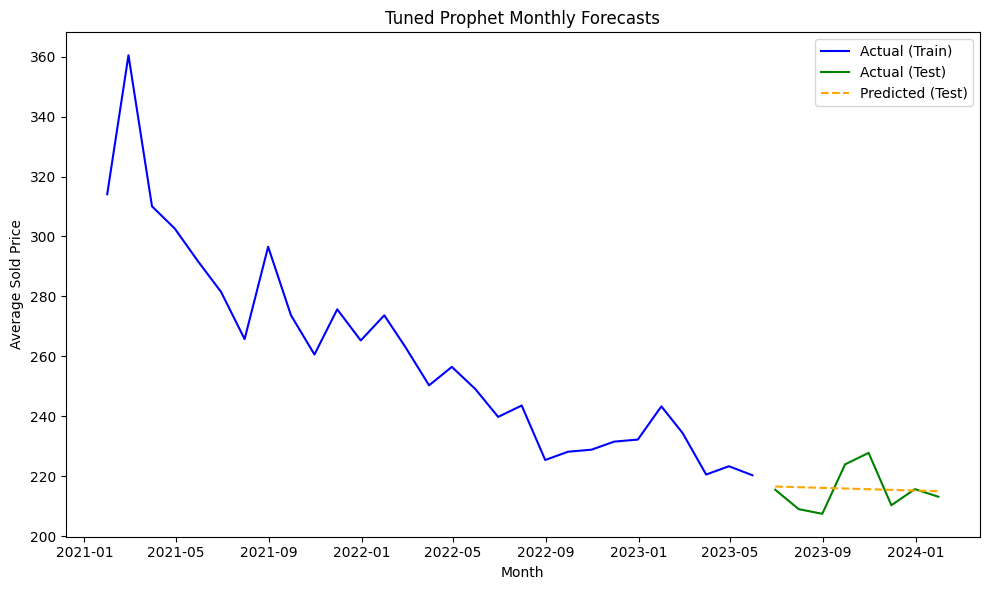

In [224]:
from prophet import Prophet
import numpy as np

# Define the parameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.01, 0.1, 1.0]
}

best_rmse = np.inf
best_params = None

for seasonality_mode in param_grid['seasonality_mode']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        for holidays_prior_scale in param_grid['holidays_prior_scale']:
            for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
                # Initialize Prophet model with current parameter combination
                model_prophet = Prophet(
                    seasonality_mode=seasonality_mode,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    changepoint_prior_scale=changepoint_prior_scale
                )
                
                try:
                    # Fit the Prophet model
                    model_prophet.fit(train_prophet)

                    # Make predictions
                    forecast = model_prophet.predict(future)
                    test_pred_prophet = forecast[-len(test):]['yhat'].values

                    # Calculate RMSE
                    rmse = np.sqrt(np.mean((test_prophet['y'].values - test_pred_prophet)**2))

                    # Check if current parameter combination improves RMSE
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {
                            'seasonality_mode': seasonality_mode,
                            'seasonality_prior_scale': seasonality_prior_scale,
                            'holidays_prior_scale': holidays_prior_scale,
                            'changepoint_prior_scale': changepoint_prior_scale
                        }
                except Exception as e:
                    print("Error:", e)
                    continue

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

# Initialize Prophet model with best parameters
model_prophet_tuned = Prophet(**best_params)

# Fit the Prophet model
model_prophet_tuned.fit(train_prophet)

# Make predictions
forecast_tuned = model_prophet_tuned.predict(future)
test_pred_prophet_tuned = forecast_tuned[-len(test):]['yhat'].values

# Calculate performance metrics
rmse_prophet_tuned = np.sqrt(np.mean((test_prophet['y'].values - test_pred_prophet_tuned)**2))
print('Tuned Prophet Model RMSE:', rmse_prophet_tuned)
mae_prophet_tuned = np.mean(np.abs(test_prophet['y'].values - test_pred_prophet_tuned))
print('Tuned Prophet Model MAE:', mae_prophet_tuned)
mape_prophet_tuned = np.mean(np.abs((test_prophet['y'].values - test_pred_prophet_tuned) / test_prophet['y'].values)) * 100
print('Tuned Prophet Model MAPE:', mape_prophet_tuned)

# Print Prophet forecast summary
print(forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot Prophet forecast
fig = plt.figure(figsize=(10, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Actual (Train)', color='blue')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual (Test)', color='green')
plt.plot(test_prophet['ds'], test_pred_prophet_tuned, label='Predicted (Test)', linestyle='--', color='orange')
plt.title('Tuned Prophet Monthly Forecasts')
plt.xlabel('Month')
plt.ylabel('Average Sold Price')
plt.legend()
plt.tight_layout()
plt.show()
